# Apple Stock Price Prediction Using an RNN

In this notebook I will implement a recurrent neural network to try and predict the 
stock price of Apple. The stock price data was taken from yahoo.com


In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [2]:
# For this example we will only try to predict the closing price
apple_data = pd.read_csv('AAPL.csv')
prices = apple_data[['Close']]

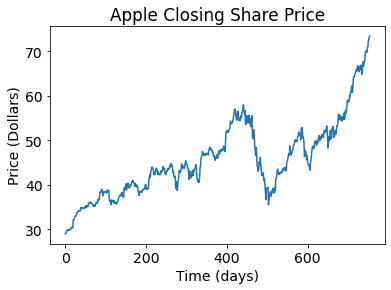

In [3]:
# Plot the closing price
# We will ignore the actual dates and just use the index as the time value
times = np.arange(prices.size)
plt.plot(times,prices,lw=1.5)
plt.xlabel('Time (days)')
plt.ylabel('Price (Dollars)')
plt.title('Apple Closing Share Price')
plt.show()

In [43]:
# Calculate log returns. This will be a feature we will use to train the model
prices['returns'] = prices.Close.pct_change()
prices['logReturns'] = np.log(1+prices['returns'])
prices.dropna(inplace=True)

750


<ipython-input-43-0b6509fbb617>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['returns'] = prices.Close.pct_change()
<ipython-input-43-0b6509fbb617>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['logReturns'] = np.log(1+prices['returns'])
<ipython-input-43-0b6509fbb617>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

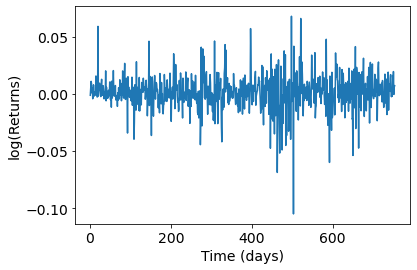

In [5]:
# Plot Log returns
plt.plot(times[1:],prices['logReturns'])
plt.xlabel('Time (days)')
plt.ylabel('log(Returns)')
plt.show()

## Scale and preprocess data
Here we will scale our data and process it into the form required by the neural network


In [51]:
# x will be the features so we fit and transform them
x = prices[['Close','logReturns']].values
scaler = MinMaxScaler(feature_range=(0,1)).fit(x)
x_scaled = scaler.transform(x)

# y is simply the closing price which is also the label we are trying to
# predict.
y = [x[0] for x in x_scaled]
print(len(y))

750


In [57]:
# Perform Train test split using 80% of data for training
x_train = x_scaled[:int(len(x_scaled)*0.8)]
y_train = y[:int(len(x_scaled)*0.8)]

x_test = x_scaled[int(len(x_scaled)*0.8):]
y_test = y[int(len(x_scaled)*0.8):]
print(x_train.shape)

(600, 2)


In [61]:
# Create batches of testing and training data using
n = 10 # number of time steps to use for each batch
xtrain = []
ytrain = []
xtest  = []
ytest  = []
for i in range(n,len(x_train)):
    xtrain.append(x_train[i-n:i,:x_train.shape[1]])
    ytrain.append(y_train[i])
for i in range(n,len(x_test)):
    xtest.append(x_test[i-n:i,:x_test.shape[1]])
    ytest.append(y_test[i])

xtrain = np.array(xtrain)
xtest  = np.array(xtest)
ytrain = np.array(ytrain)
ytest  = np.array(ytest)
print(xtrain.shape)

(590, 10, 2)


## Create RNN Model

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50,input_shape=(xtrain.shape[1],xtrain.shape[2]),
                               return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(50,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(50,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='relu'))
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.01))

In [11]:
model.fit(xtrain,ytrain,epochs=500,batch_size=10,verbose=0)

In [12]:
model.summary()
# Make predictions on the testing and training data
trainPred = model.predict(xtrain)
testPred  = model.predict(xtest)
testPred.shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 11)            616       
_________________________________________________________________
dropout (Dropout)            (None, 10, 11)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 11)                1012      
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12        
Total params: 1,640
Trainable params: 1,640
Non-trainable params: 0
_________________________________________________________________


(141, 1)

In [13]:
# Perform inverse transform to convert predictions back to dollar values
trainPred = np.c_[trainPred,np.zeros(trainPred.shape)]
testPred  = np.c_[testPred,np.zeros(testPred.shape)]

trainPred = scaler.inverse_transform(trainPred)
testPred  = scaler.inverse_transform(testPred)

trainPred = [x[0] for x in trainPred]
testPred  = [x[0] for x in testPred]

In [19]:
# Calculate root mean square error
rmse = np.sqrt(np.mean(trainPred-ytrain)**2)
print('RMSE for training data: %.3f' % rmse)

rmse = np.sqrt(np.mean(testPred-ytest)**2)
print('RMSE for testing data: %.3f' % rmse)

RMSE for training data: 42.709
RMSE for testing data: 52.728


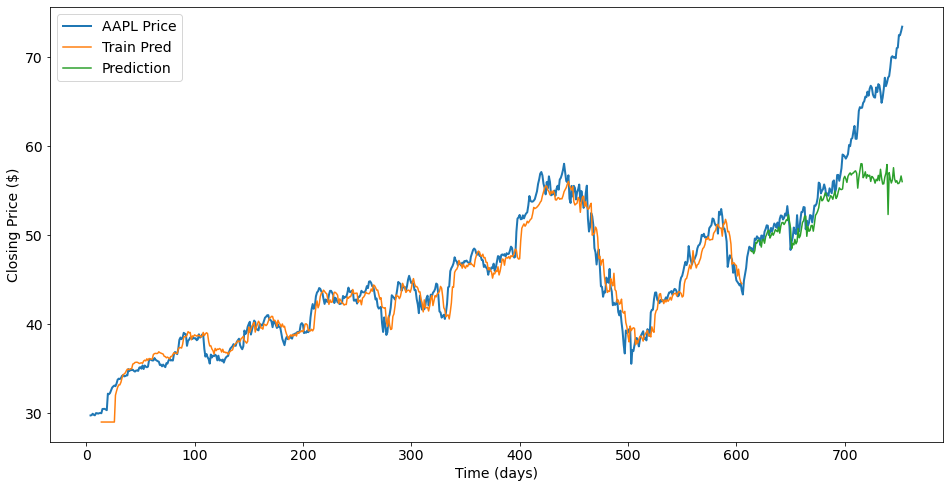

In [60]:
# Plot predictions vs true values
# train = prices[:len(x_train)]
# valid = prices[len(x_train):]
# valid['predictions'] = testPred

plt.figure(figsize=(16,8))
plt.plot(prices.index,prices['Close'],lw=2.0,label='AAPL Price')
plt.plot(prices.index[10:len(trainPred)+10],trainPred,label='Train Pred')
plt.plot(prices.index[-len(testPred):],testPred,label='Prediction')
# plt.plot(train['Close'])
# plt.plot(valid[['Close','Predictions']])
plt.xlabel('Time (days)')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()